In [4]:
import pandas as pd 
import numpy as np

from helpers import compute_perc

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.gridspec as gridspec

import statsmodels.api as sm 
import statsmodels.formula.api as smf

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from scipy.stats import shapiro
from scipy.stats import ttest_1samp, probplot

import random

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
np.random.seed(42)
random.seed(42)

First, we need to verify the integrity of the data provided by Don Francesco. <br>
We will check for any missing values (often referred to as 'NaNs' in technical terms) or values that seem inappropriate.

In [6]:
# Import the dataset 
df = pd.read_csv('./datasets/diamonds/diamonds.csv')

# Check for missing values
print(len(df), ' Total rows')
print(df.isna().to_numpy().sum(), ' Missing values')

# Check non-positive prices 
print((df['price']<=0).to_numpy().sum(), 'Non positive prices')

# Check for non-positive lengths
print((df['x']<=0).to_numpy().sum(), 'Non positive x')
print((df['y']<=0).to_numpy().sum(), 'Non positive y')
print((df['z']<=0).to_numpy().sum(), 'Non positive z')

# Show rows with anomalies
df[(df['price']<=0)|(df['x']<=0)|(df['y']<=0)|(df['z']<=0)]

5000  Total rows
0  Missing values
10 Non positive prices
1 Non positive x
1 Non positive y
1 Non positive z


,carat,cut,color,clarity,depth,table,price,x,y,z
331,1.00,Good,F,SI1,64.1,60.0,-1,6.25,6.19,3.99
2121,0.34,Ideal,E,VS2,59.8,56.0,-1,4.55,4.54,2.72
2484,1.75,Ideal,J,SI1,63.3,59.0,-1,7.63,7.57,4.81
2933,1.51,Ideal,H,VS2,62.5,55.0,-1,7.29,7.34,4.57
3155,0.31,Ideal,G,VS2,61.7,57.0,-1,4.33,4.36,2.68
3317,1.02,Premium,D,VS2,59.8,61.0,-1,6.61,6.54,3.93
3445,0.30,Premium,H,SI1,59.3,59.0,-1,4.38,4.36,2.59
3904,0.90,Very Good,G,SI2,64.2,56.0,-1,6.04,6.11,3.90
3980,0.41,Very Good,H,VS2,63.4,58.0,-1,4.77,4.66,2.99
4188,0.79,Ideal,H,VVS1,62.0,56.0,-1,5.92,5.96,3.68


We have a small number of anomalies (11/5000). We can simply remove them.

In [7]:
idx = (df['price']<=0)|(df['x']<=0)|(df['y']<=0)|(df['z']<=0)
df = df[~idx]
df.head(15)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82
5,0.32,Ideal,G,IF,61.7,54.0,918,4.39,4.42,2.72
6,0.30,Very Good,H,IF,62.9,58.0,789,4.26,4.29,2.69
7,0.61,Ideal,E,VVS2,61.3,54.0,2823,5.51,5.59,3.40
8,2.01,Premium,G,SI2,61.2,57.2,18705,8.08,8.14,4.97
9,0.31,Ideal,I,VS1,61.2,55.0,507,4.37,4.39,2.68


We seek to find what matters most in determining the price of a diamond. <br>
We are provided with a total of 10 possible predictors of the price. 7 of them are numerical (carat, depth, table, x, y, z) and 3 of them are categorical (color, clarity and cut). 

Let's inspect the categorical quantities.

In [8]:
categorical_variables = ['cut', 'color', 'clarity']
numerical_variables = ['carat', 'depth', 'table', 'x', 'y', 'z']

# Look at the distribution of the categorical variables. compute_perc() is a helper function defined in helpers.py
for c in categorical_variables:
    print(c+'\t\t', len(df.cut.unique()), 'Unique cut attributes', [x for x in compute_perc(df, c)])

cut		 5 Unique cut attributes ['Ideal 0.4', 'Premium 0.26', 'Very Good 0.22', 'Good 0.09', 'Fair 0.03']
color		 5 Unique cut attributes ['H 0.15', 'I 0.1', 'F 0.17', 'G 0.22', 'E 0.18', 'D 0.12', 'J 0.05']
clarity		 5 Unique cut attributes ['SI2 0.17', 'SI1 0.24', 'VS2 0.23', 'IF 0.03', 'VVS2 0.09', 'VS1 0.16', 'I1 0.01', 'VVS1 0.07']


In [9]:
# Look at the main statistics of the numerical quantities
df.describe()

,carat,depth,table,price,x,y,z
count,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000
mean,0.794117,61.710844,57.446242,3930.581880,5.726232,5.728821,3.533678
std,0.467981,1.445563,2.259752,3970.923311,1.116257,1.109167,0.688437
min,0.230000,44.000000,51.600000,351.000000,3.860000,3.840000,1.410000
25%,0.400000,61.000000,56.000000,942.000000,4.700000,4.710000,2.900000
50%,0.700000,61.800000,57.000000,2398.000000,5.690000,5.700000,3.530000
75%,1.040000,62.500000,59.000000,5376.000000,6.540000,6.540000,4.030000
max,4.130000,70.200000,95.000000,18787.000000,10.000000,9.850000,6.430000


Upon initial inspection, it is evident that the price of diamonds varies significantly within the dataset, spanning approximately two orders of magnitude. Similarly, the weight of each diamond (carat) also varies considerably, spanning about one order of magnitude. In contrast, the other attributes (table, depth, x, y, z) show much less variability.

**Technical note**: Given the substantial variability in "carat" and "price," it is advantageous to analyze their logarithmic transformations, namely log(carat) and log(price). This approach facilitates modeling multiplicative interactions between predictors if needed.

Additionally, since clarity and color levels can be ranked on a scale, let's introduce their corresponding numerical values as well.

In [10]:
# define log quantities
df['log_price'] = np.log(df['price'])
df['log_carat'] = np.log(df['carat'])

# Define numerical color variable
colors_numerical_values = {}
for i, l in enumerate(sorted(df.color.unique(), reverse=True)): 
    colors_numerical_values[l] = i + 1

#define numerical clarity variable
clarity_numerical_values = {
    'I1':   1,
    'SI2':  2,
    'SI1':  3,
    'VS2':  4,
    'VS1':  5,
    'VVS2': 6,
    'VVS1': 7,
    'IF':   8,
}

# add numerical clarity and color variables
df[['clarity_num', 'color_num']] = df.apply(
    lambda x: pd.Series({
        'clarity_num':  clarity_numerical_values[x['clarity']],
        'color_num':    colors_numerical_values[x['color']]
    }), axis = 1
)
numerical_variables += ['color_num', 'clarity_num']

df.describe()

,carat,depth,table,price,x,y,z,log_price,log_carat,clarity_num,color_num
count,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000
mean,0.794117,61.710844,57.446242,3930.581880,5.726232,5.728821,3.533678,7.783717,-0.398688,4.059130,4.392463
std,0.467981,1.445563,2.259752,3970.923311,1.116257,1.109167,0.688437,1.019371,0.583952,1.631902,1.691265
min,0.230000,44.000000,51.600000,351.000000,3.860000,3.840000,1.410000,5.860786,-1.469676,1.000000,1.000000
25%,0.400000,61.000000,56.000000,942.000000,4.700000,4.710000,2.900000,6.848005,-0.916291,3.000000,3.000000
50%,0.700000,61.800000,57.000000,2398.000000,5.690000,5.700000,3.530000,7.782390,-0.356675,4.000000,4.000000
75%,1.040000,62.500000,59.000000,5376.000000,6.540000,6.540000,4.030000,8.589700,0.039221,5.000000,6.000000
max,4.130000,70.200000,95.000000,18787.000000,10.000000,9.850000,6.430000,9.840920,1.418277,8.000000,7.000000


## Distributions and Correlations

Let's examine the pairwise correlations of the variables. Correlation between two variables measures how closely they move together. A positive correlation indicates that they tend to increase or decrease together, while a negative correlation means one variable increases as the other decreases. A correlation close to 1 indicates a strong positive relationship, close to -1 indicates a strong negative relationship, and close to 0 indicates little to no relationship.

We can visualize these pairwise correlations in the plot below. Strongly correlated pairs will be represented in blue, strongly negatively correlated pairs in red, and uncorrelated pairs in white.

Correlations (visual)

<Axes: >

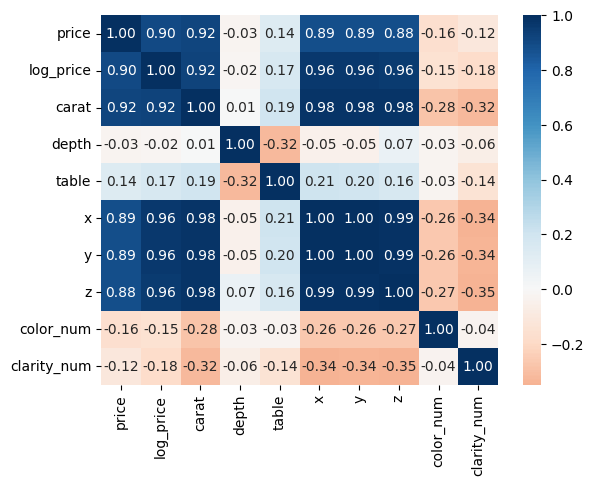

In [11]:
# visual representation of the correlation
sns.heatmap( df[['price', 'log_price']+numerical_variables].corr(), annot=True, fmt=".2f", cmap = 'RdBu', center = 0)

**(Technical) Observations**:

1. Price (and log-price) shows strong correlations with the linear dimensions (x, y, z) and carat. This indicates that these factors are likely significant in determining diamond pricing.
2. There is no apparent preference among the linear dimensions (x, y, z); their correlations with price are similar.
3. The linear dimensions are positively correlated with carat.
4. Points 2 and 3 make sense, as the volume of a diamond is proportional to its weight. Heavier diamonds tend to occupy more volume, assuming consistent specific weight across diamonds. We will verify this assumption in subsequent sections. 

We can consider using only the "carat" variable instead of the linear dimensions, to remove collinear variables.

Next, let's delve deeper into point 4 by analyzing the variability of weight per unit volume. We will approximate volume as the product of the linear dimensions.

### Assessing weight per unit volume
We are interested in assessing weather the specific volume of the diamonds in the dataset is remains roughly constant. To do this, let's look at the variability of this quantity in the dataset

wpv min 0.0031004960049488884
wpv max 0.018947216843317887
wpv mean 0.006126995581967746
wpv std 0.00022137010477819787
wpv std/mean 3.61 %
Volume std/mean 58.51 %
Carat std/mean 58.93 %


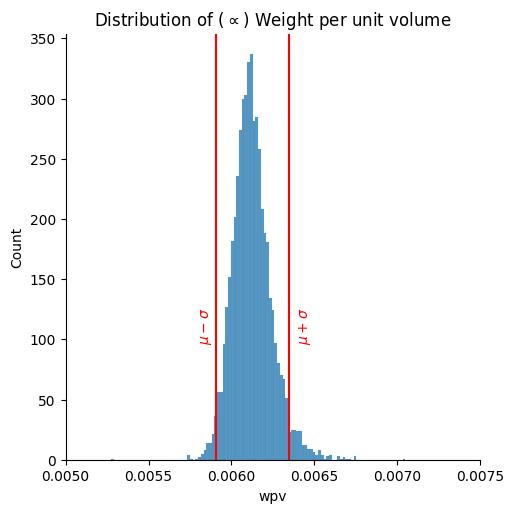

In [12]:
# Compute weight per unit volume (WPV)
df['wpv'] = df['carat']/(df.x*df.y*df.z)

# Make plot
sns.displot(df['wpv'])
plt.xlim(0.005, 0.0075)
plt.title('Distribution of ($\propto$) Weight per unit volume')
plt.axvline(x = df['wpv'].mean() + df['wpv'].std(), c = 'red')
plt.text(df['wpv'].mean() + df['wpv'].std() + 0.00005, 100, '$\mu + \sigma$', rotation = 90, c = 'red')
plt.axvline(x = df['wpv'].mean() - df['wpv'].std(), c = 'red')
plt.text(df['wpv'].mean() - df['wpv'].std() - 0.0001, 100, '$\mu - \sigma$', rotation = 90, c = 'red')

# Print relevant quantities to asses the variability of WPV
print('wpv min', min(df['wpv']) )
print('wpv max', max(df['wpv']))
print('wpv mean', df['wpv'].mean())
print('wpv std', df['wpv'].std())
print("wpv std/mean {:.{}f} %".format(df['wpv'].std() / df['wpv'].mean()*100,  2))
print('Volume std/mean {:.{}f} %'.format((df.x*df.y*df.z).std() / (df.x*df.y*df.z).mean()*100,  2))
print('Carat std/mean {:.{}f} %'.format(df['carat'].std() / df['carat'].mean()*100,  2))


We observe a narrow, uni-modal distribution. 

Furthermore the variability of the weight per unit volume (measured as $\sigma(wpv)/ \mu(wpv)$) is very low (about 3,6 %) compared to the variability of the carat and volume variables (about 58%). 

Therefore we can state that the weight per unit volume is approximately the same across all diamonds (as expected) and we don't need to include terms like $x\times y\times z$.

## Pairwise distributions plot
Finally, let's look at the joint distributions for each pair of numerical variable at hand

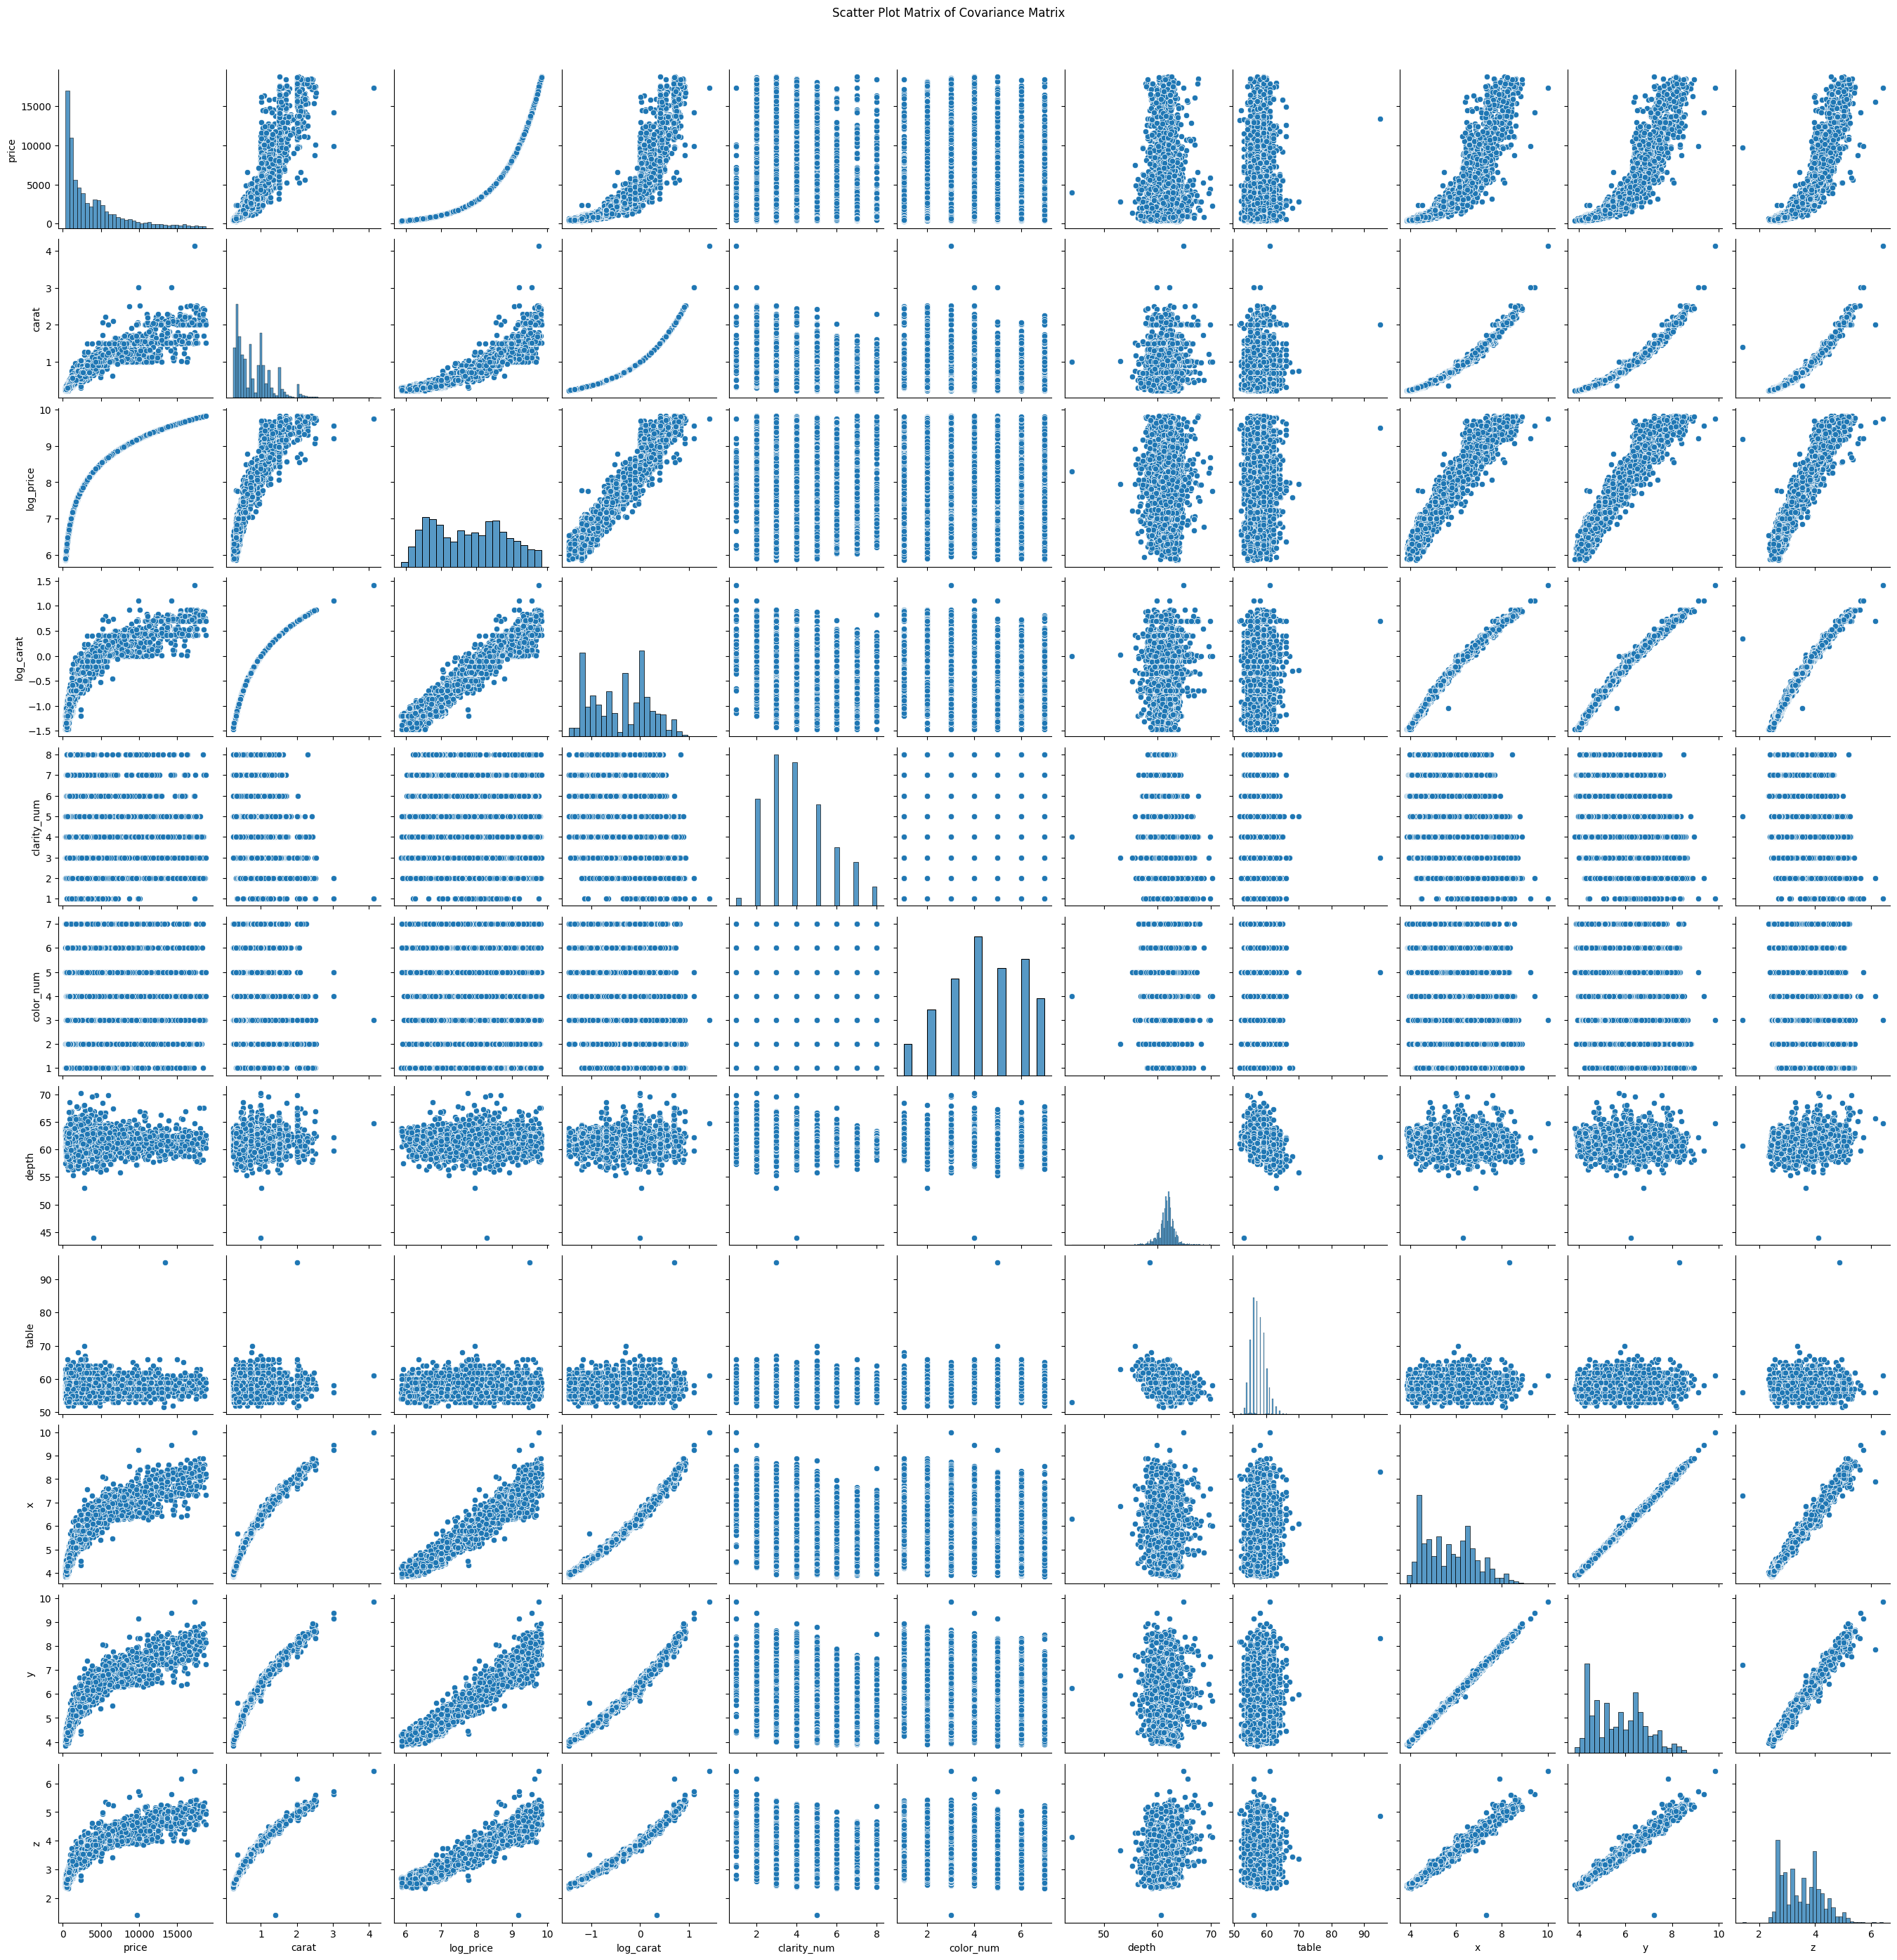

In [13]:
vars_order = [
    'price',
    'carat',
    'log_price',
    'log_carat',
    'clarity_num',
    'color_num',
    'depth',
    'table',
    'x',
    'y',
    'z']


# plot the pairwise distributions of the dataset
sns.pairplot(df, kind='scatter', vars = vars_order)
plt.suptitle('Scatter Plot Matrix of Covariance Matrix', y=1.02)
plt.show()

The following final visualization of price as a function of color, clarity and carat can be insightful. <br>

Text(0.5, 0.98, 'Visualization of price as a function of carat, color and clarity')

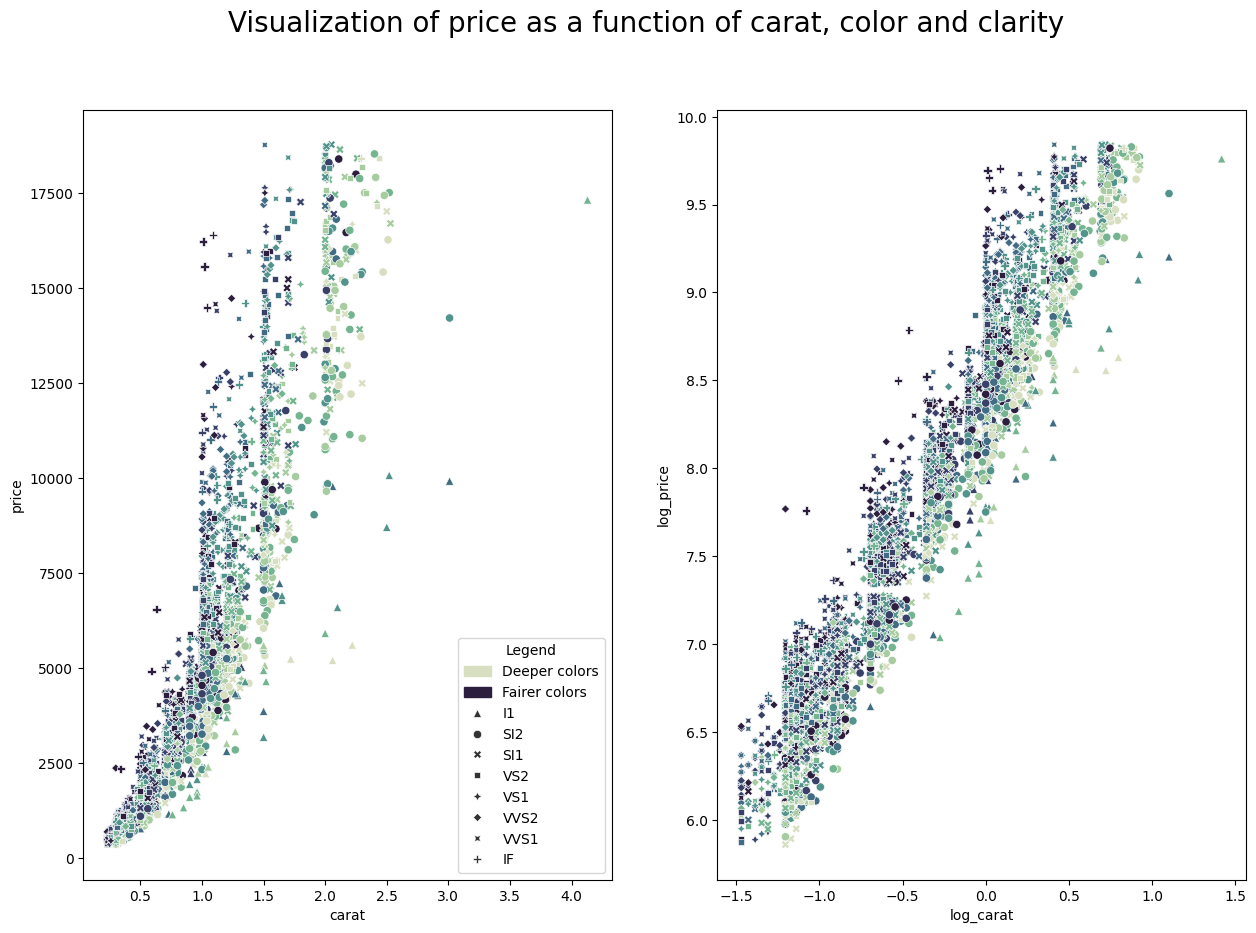

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (15, 10))

# Create a cubehelix palette
cubehelix_palette = sns.cubehelix_palette(start=0.5, rot=-0.75, as_cmap=True)

# Create the scatter plot with hue for 'color_num' and style for 'clarity', hiding the default legend
scatter = sns.scatterplot(x='carat', y='price', hue='color_num', style='clarity', palette=cubehelix_palette, data=df, ax = axes[0])
scatter = sns.scatterplot(x='log_carat', y='log_price', hue='color_num', style='clarity', palette=cubehelix_palette, data=df, ax = axes[1])

# Create custom legend entries for color_num
color_handles = [
    mpatches.Patch(color=cubehelix_palette(0), label='Deeper colors'),
    mpatches.Patch(color=cubehelix_palette(1000), label='Fairer colors')
]

# Filter out the color handles from the existing legend
handles, labels = scatter.get_legend_handles_labels()
clarity_handles = [ handles[labels.index(l)] for l in list(clarity_numerical_values.keys())]

# Add the custom legend to the plot
axes[0].legend(handles=color_handles + clarity_handles, title='Legend')
axes[1].legend().remove()

plt.suptitle('Visualization of price as a function of carat, color and clarity', fontsize = 20)

The shapes are in increasing order of clarity (IF being the clearest and I1 the least clear)

**Observations**: 
1. The log log plot appears to be linear (the data are distributed approximately along a straight line)
2. This suggests that the relationship between carat ($c$) and price ($p$) is of the form 
$$log p = \alpha_0 + \alpha_1 log c$$
Or, equivalently: 
$$ p = \alpha_0 \cdot c^{\alpha_1}$$

3. The gradient of color also suggests that fairer colors  (color labels 'D', 'E', etc) are more expensive than darker colors (color labels 'D', 'J', etc.)
4. By looking at the shapes of the data, we can also see that clearer ('IF', 'VVS1', etc.) diamonds are associated to higher prices



## Linear models

Let's now try to provide a more quantitative answer to the question "What makes a diamond valuable?".

Don Francesco is interested in simplicity and interpretability, so we can use the simplest and most interpretable models: linear models. We will fit a set of nested linear models, including predictors increasingly less correlated with the "price" variable.

To assess the goodness of the fit, we can use the standard ANOVA test and some additional metrics likw
1. R Squared and Adjusted R Squared, which capture the fraction of the variance in the data explained by the model
2. The mean of the absolute error
3. The mean of the relative error (which could be more appropriate in our case, given that we are trying to predict the price)

In [15]:
df[numerical_variables+['price']].corr()['price'].abs().sort_values(ascending = False)

price          1.000000
carat          0.920831
y              0.887911
x              0.887051
z              0.880601
color_num      0.164323
table          0.140989
clarity_num    0.115313
depth          0.025135
Name: price, dtype: float64

In [16]:
# analyze results with ANOVA and some additional metrics
def meanabs(y_pred, y_true):
    y_pred = np.asarray(y_pred).ravel()
    y_true = np.asarray(y_true).ravel()
    error = y_pred - y_true
    error = np.abs(error)
    error = np.nanmean(error)
    return error

# Use this
def meanabsperc(y_pred, y_true):
    y_pred = np.asarray(y_pred).ravel()
    y_true = np.asarray(y_true).ravel()
    error = y_pred - y_true
    error = np.abs(error)
    error = np.nanmean(error)
    return error

# Use this
def rootmeansq(y_pred, y_true):
    y_pred = np.asarray(y_pred).ravel()
    y_true = np.asarray(y_true).ravel()
    error = y_pred - y_true
    error = np.nanmean(error**2)
    return np.sqrt(error)

def medrel(y_pred, y_true):
    y_pred = np.asarray(y_pred).ravel()
    y_true = np.asarray(y_true).ravel()
    error = (y_pred - y_true)/y_true
    error = np.abs(error)
    error = np.nanmedian(error)
    return error

def rmedspe(y_pred, y_true):
    y_pred = np.asarray(y_pred).ravel()
    y_true = np.asarray(y_true).ravel()
    error = (y_pred - y_true)/y_true
    error = np.nanmedian(error**2)
    return np.sqrt(error)

def r_squared(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mean_y = np.mean(y_true)
    ss_tot = np.sum((y_true - mean_y)**2)
    ss_res = np.sum((y_true - y_pred)**2)
    r2 = 1 - ss_res / ss_tot
    return r2

def adjusted_r_squared(y_true, y_pred, n_features):
    r2 = r_squared(y_true, y_pred)
    n = len(y_true)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    return adj_r2

def compute_metrics(models, df, dependent_variable, results = None):
    if results is None : results = pd.DataFrame()
    results['r2'] = [m.rsquared for m in models]
    results['r2_adj'] = [m.rsquared_adj for m in models]
    results['meanabs'] = [meanabs(m.predict(df), df[dependent_variable]) for m in models]
    results['rootmeansq'] = [rootmeansq(m.predict(df), df[dependent_variable]) for m in models]
    results['meanabsperc'] = [meanabsperc(m.predict(df), df[dependent_variable]) for m in models]
    return results


def custom_anova(df, models, dependent_variable): 
    anova_results = anova_lm(*models)
    anova_results = compute_metrics(models, df, dependent_variable, results = anova_results)       

    return anova_results

In [17]:
#  fit simple linear models
models_f = [
    'price ~ carat',
    'price ~ carat + color',
    'price ~ carat + color + clarity',
    'price ~ carat + color + clarity + depth',
    'price ~ carat + color + clarity + depth + table',
]
models = [
    ols(formula=formula, data=df).fit() for formula in models_f
]
anova_results_linear = custom_anova(df, models, dependent_variable='price')
anova_results_linear.index = [m[8:] for m in models_f]
anova_results_linear

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F),r2,r2_adj,meanabs,rootmeansq,meanabsperc
carat,4987.0,1.196059e+10,0.0,NaN,NaN,NaN,0.847930,0.847900,1014.244241,1548.351331,1014.244241
carat + color,4981.0,1.082718e+10,6.0,1.133412e+09,139.823900,2.808251e-164,0.862341,0.862147,984.613688,1473.163116,984.613688
carat + color + clarity,4974.0,6.784068e+09,7.0,4.043107e+09,427.525429,0.000000e+00,0.913746,0.913503,816.240248,1166.106851,816.240248
carat + color + clarity + depth,4973.0,6.778103e+09,1.0,5.964964e+06,4.415222,3.566984e-02,0.913822,0.913562,816.270386,1165.594083,816.270386
carat + color + clarity + depth + table,4972.0,6.717171e+09,1.0,6.093203e+07,45.101436,2.080373e-11,0.914596,0.914321,812.057057,1160.343178,812.057057


Let's also add some visualizations of the metrics

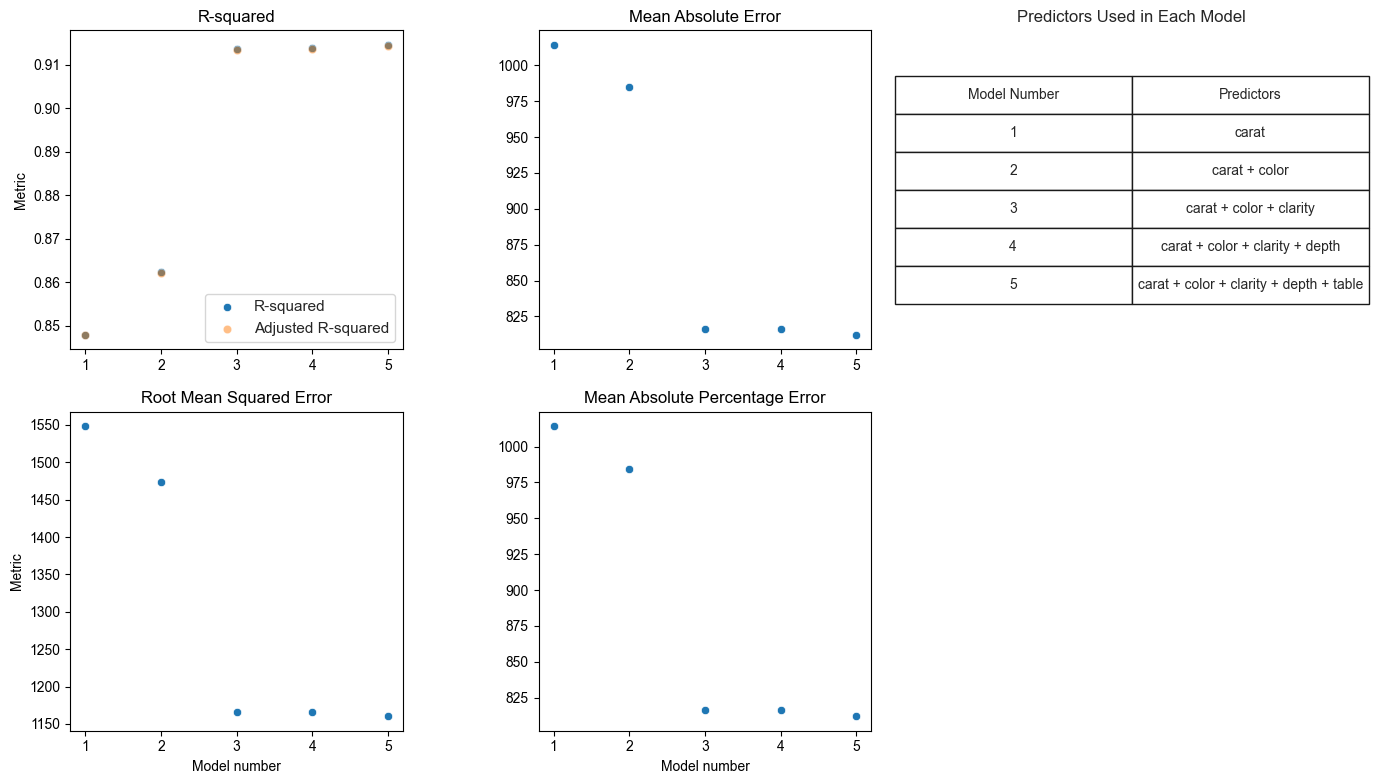

In [18]:
predictors_data = {
    'Model Number': np.arange(1, len(models_f) + 1),
    'Predictors': [m[len('price ~ '):] for m in models_f]
}

# Create predictors DataFrame
predictors_df = pd.DataFrame(predictors_data)

# Set up the figure and gridspec
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 3, width_ratios=[2, 2, 1.5])

# Original 2x2 subplots
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1])
axes = [ax1, ax2, ax3, ax4]

sns.set(style="whitegrid")
_ = sns.scatterplot(x=1 + np.arange(len(anova_results_linear), dtype = np.int16), y='r2',           data=anova_results_linear, ax=axes[0], label="R-squared")
_ = sns.scatterplot(x=1 + np.arange(len(anova_results_linear), dtype = np.int16), y='r2_adj',       data=anova_results_linear, ax=axes[0], label="Adjusted R-squared", alpha=0.5)
_ = sns.scatterplot(x=1 + np.arange(len(anova_results_linear), dtype = np.int16), y='meanabs',      data=anova_results_linear, ax=axes[1], label="Mean Absolute Error")
_ = sns.scatterplot(x=1 + np.arange(len(anova_results_linear), dtype = np.int16), y='rootmeansq',   data=anova_results_linear, ax=axes[2], label="Root Mean Squared Error")
_ = sns.scatterplot(x=1 + np.arange(len(anova_results_linear), dtype = np.int16), y='meanabsperc',  data=anova_results_linear, ax=axes[3], label="Mean Absolute Percentage Error")

axes[0].set_title("R-squared")
axes[1].set_title("Mean Absolute Error")
axes[2].set_title("Root Mean Squared Error")
axes[3].set_title("Mean Absolute Percentage Error")

# Remove the name of the y axis 
axes[0].set_ylabel("Metric")
axes[1].set_ylabel("")
axes[2].set_ylabel("Metric")
axes[3].set_ylabel("")

# Remove the name of the x axis
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("Model number")
axes[3].set_xlabel("Model number")

# Set x ticks
for i in range(4): axes[i].set_xticks(np.arange(1, len(anova_results_linear) + 1, dtype = np.int16))

# Remove the legend from the subplots
for i in range(1, 4): axes[i].legend().remove()

# Adding the new panel for predictors
ax5 = plt.subplot(gs[0, 2])
table = plt.table(cellText=predictors_df.values, colLabels=predictors_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.9, 2)

ax5.axis('off')
ax5.set_title('Predictors Used in Each Model')

# Adjust layout to fit everything neatly
plt.tight_layout()
plt.show()

The F-statistic is very low for all models, indicating that, with a high confidence level, the F-test would assert that all the predictors should be included in the model. However, all metrics (including the F-statistic) improve dramatically when the predictors "carat," "color," and "clarity" are included.

In contrast, adding other predictors only marginally improves (or even deteriorates) the model's performance. <br>
This is a hint that "carat," "color," and "clarity" are the most important predictors.

## Log linear models

Let's now try to implement a set of nested log-linear models, motivated by the observations in the exploratory data analysis.

In [19]:
# Compute log quantities
df['log_depth'] = np.log(df.depth)
df['log_table'] = np.log(df.table)

#  fit simple linear models
models_f = [
    'log_price ~ log_carat',
    'log_price ~ log_carat + clarity',
    'log_price ~ log_carat + clarity + color',
    'log_price ~ log_carat + clarity + color + log_table',
    'log_price ~ log_carat + clarity + color + log_table + log_depth',
]

models = [
    ols(formula=formula, data=df).fit() for formula in models_f
]
anova_results_linear = custom_anova(df, models, dependent_variable='log_price')
anova_results_linear.index = [m[8:] for m in models_f]
anova_results_linear

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F),r2,r2_adj,meanabs,rootmeansq,meanabsperc
e ~ log_carat,4987.0,345.837879,0.0,NaN,NaN,NaN,0.933276,0.933263,0.205602,0.263287,0.205602
e ~ log_carat + clarity,4980.0,178.582925,7.0,167.254954,1255.824475,0.000000e+00,0.965545,0.965490,0.148763,0.189197,0.148763
e ~ log_carat + clarity + color,4974.0,95.962427,6.0,82.620498,723.743290,0.000000e+00,0.981486,0.981433,0.109097,0.138690,0.109097
e ~ log_carat + clarity + color + log_table,4973.0,95.122375,1.0,0.840052,44.152388,3.363354e-11,0.981648,0.981592,0.108588,0.138081,0.108588
e ~ log_carat + clarity + color + log_table + log_depth,4972.0,94.598255,1.0,0.524120,27.547291,1.596743e-07,0.981749,0.981690,0.108271,0.137700,0.108271


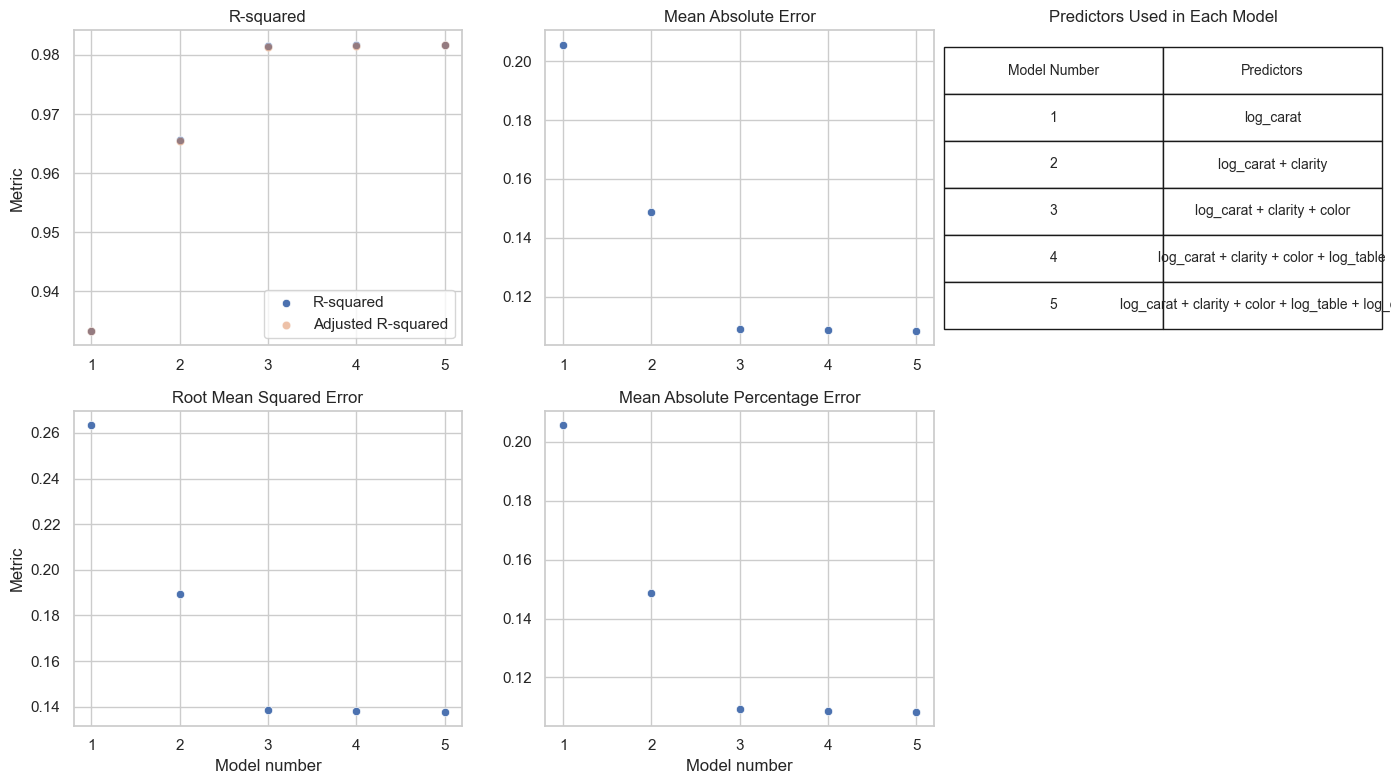

In [20]:
predictors_data = {
    'Model Number': np.arange(1, len(models_f) + 1),
    'Predictors': [m[len('log_price ~ '):] for m in models_f]
}

# Create predictors DataFrame
predictors_df = pd.DataFrame(predictors_data)

# Set up the figure and gridspec
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 3, width_ratios=[2, 2, 1.5])

# Original 2x2 subplots
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1])
axes = [ax1, ax2, ax3, ax4]

sns.set(style="whitegrid")
_ = sns.scatterplot(x=1 + np.arange(len(anova_results_linear), dtype = np.int16), y='r2',           data=anova_results_linear, ax=axes[0], label="R-squared")
_ = sns.scatterplot(x=1 + np.arange(len(anova_results_linear), dtype = np.int16), y='r2_adj',       data=anova_results_linear, ax=axes[0], label="Adjusted R-squared", alpha=0.5)
_ = sns.scatterplot(x=1 + np.arange(len(anova_results_linear), dtype = np.int16), y='meanabs',      data=anova_results_linear, ax=axes[1], label="Mean Absolute Error")
_ = sns.scatterplot(x=1 + np.arange(len(anova_results_linear), dtype = np.int16), y='rootmeansq',   data=anova_results_linear, ax=axes[2], label="Root Mean Squared Error")
_ = sns.scatterplot(x=1 + np.arange(len(anova_results_linear), dtype = np.int16), y='meanabsperc',  data=anova_results_linear, ax=axes[3], label="Mean Absolute Percentage Error")

axes[0].set_title("R-squared")
axes[1].set_title("Mean Absolute Error")
axes[2].set_title("Root Mean Squared Error")
axes[3].set_title("Mean Absolute Percentage Error")

# Remove the name of the y axis 
axes[0].set_ylabel("Metric")
axes[1].set_ylabel("")
axes[2].set_ylabel("Metric")
axes[3].set_ylabel("")

# Remove the name of the x axis
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("Model number")
axes[3].set_xlabel("Model number")

# Set the ticks for the x axis
for i in range(4): axes[i].set_xticks(np.arange(1, len(anova_results_linear) + 1, dtype = np.int16))

# Remove the legend
for i in range(1, 4): axes[i].legend().remove()

# Adding the new panel for predictors
ax5 = plt.subplot(gs[0, 2])
table = plt.table(cellText=predictors_df.values, colLabels=predictors_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.5, 2.5)

ax5.axis('off')
ax5.set_title('Predictors Used in Each Model')

# Adjust layout to fit everything neatly
plt.tight_layout()
plt.show()

The results for the log linear models suggest qualitatively similar results. 
The predictors: "carat," "color," and "clarity" appear to be the most important ones, and the most parsimonious and best model is:
$$ price = \alpha_0 \cdot (carat)^{\alpha_1} \times (color) \times (clarity)$$

The models with categorical variables "color_num" and "clarity_num" were also fitted, yielding  similar results (omitted for brevity).

## Residual analysis
To verify that the fit produces meaningful results, let's analyze the residuals (errors). <br>

We want to assess:
1. That they have a zero mean 
2. That they are normally distributed or at least distributed with a bell-shaped curve
3. That they are not correlated with any of the predictors

In [21]:
def run_statistical_Test(residuals):
    # Perform one-sample t-test for mean
    statistic, p_value = ttest_1samp(residuals, 0)

    print(f"One-sample T-test Results:")
    print(f"Statistic: {statistic}")
    print(f"P-value: {p_value}")

    # Interpret the results
    alpha = 0.05  # Significance level
    if p_value > alpha:
        print("Residuals have a mean of zero (fail to reject H0)")
    else:
        print("Residuals do not have a mean of zero (reject H0)")

    # Perform Shapiro-Wilk test for normality
    statistic, p_value = shapiro(residuals)

    print(f"Shapiro-Wilk Test Results:")
    print(f"Statistic: {statistic}")
    print(f"P-value: {p_value}")

    # Interpret the results
    alpha = 0.05  # Significance level
    if p_value > alpha:
        print("Residuals are normally distributed (fail to reject H0)")
    else:
        print("Residuals are not normally distributed (reject H0)")

Assessing model log_price ~ log_carat
One-sample T-test Results:
Statistic: 5.463191604816412e-14
P-value: 0.9999999999999565
Residuals have a mean of zero (fail to reject H0)
Shapiro-Wilk Test Results:
Statistic: 0.993051379612902
P-value: 7.008346013982755e-15
Residuals are not normally distributed (reject H0)


Text(0.5, 0.98, 'Residual analysis, model: log_price ~ log_carat')

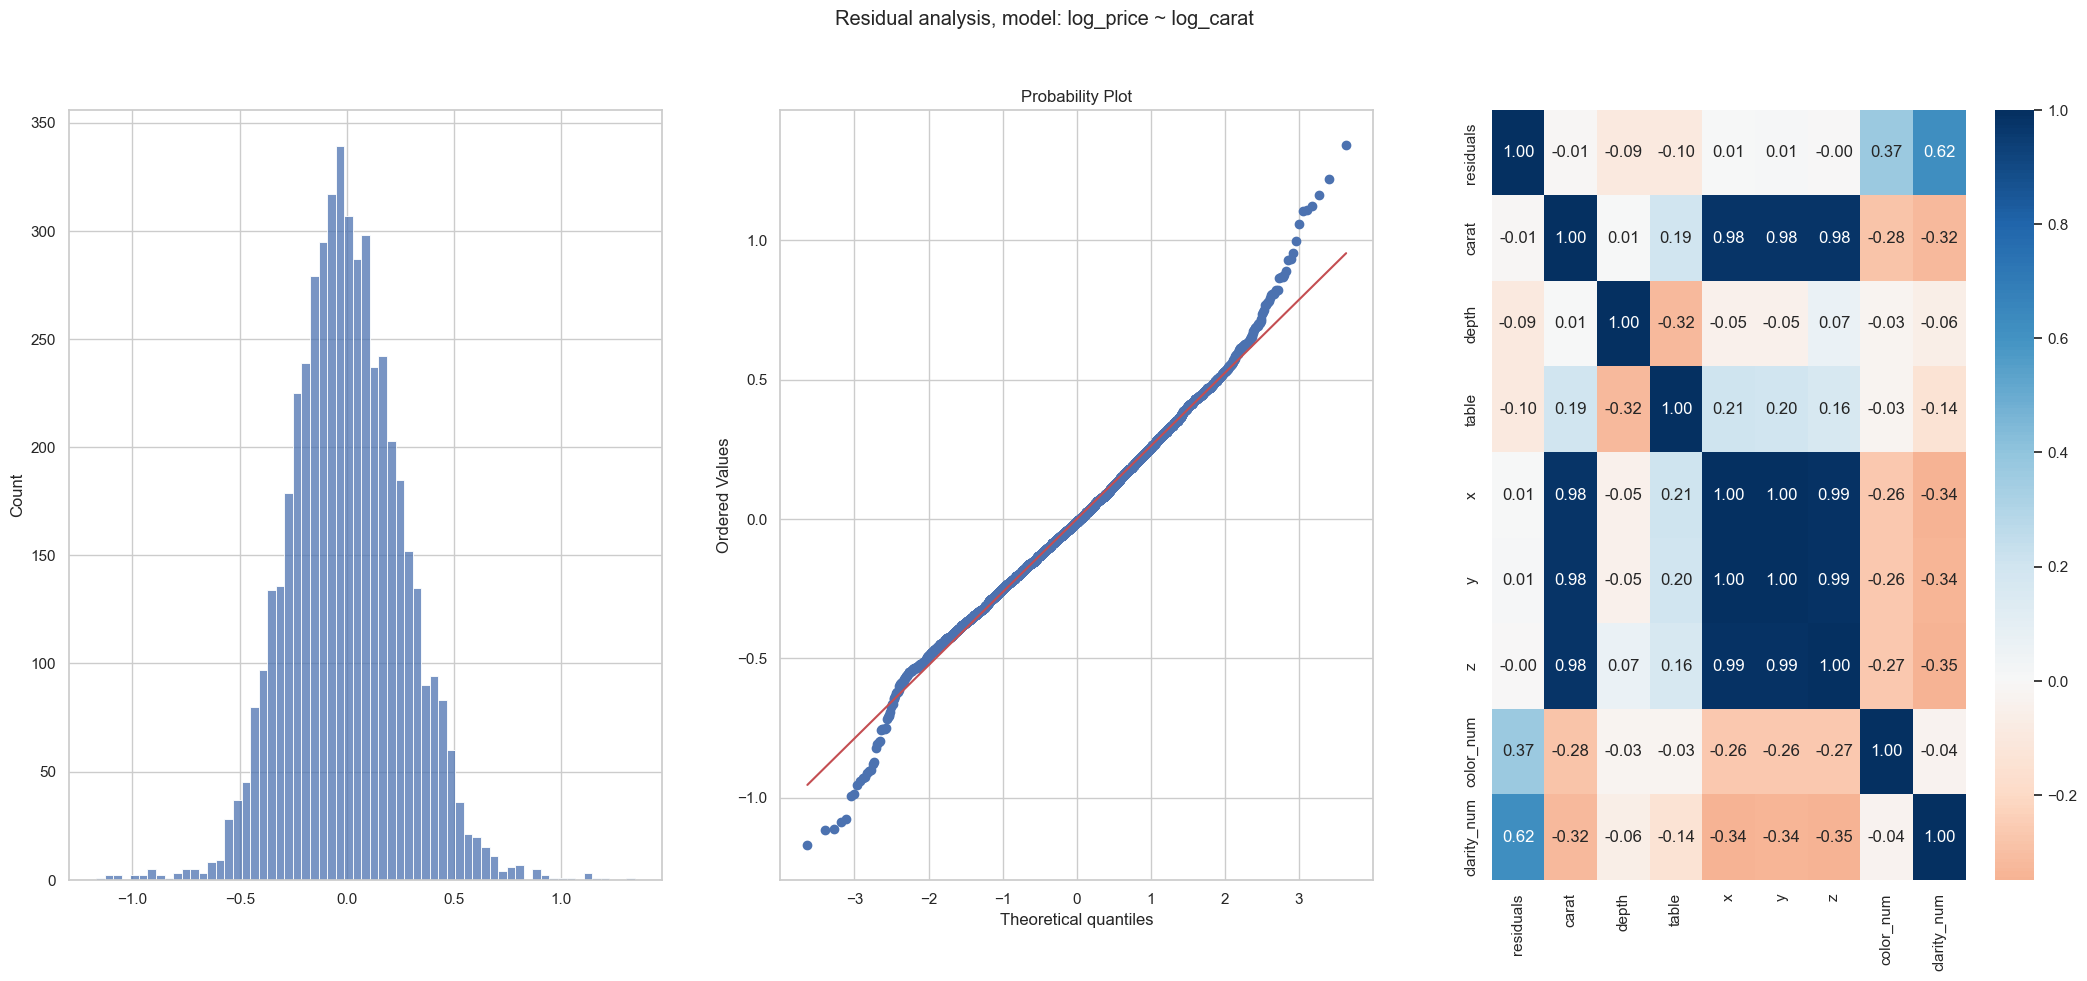

In [22]:
# Select the model to assess
model_idx = 0

# Run statistical test
print('Assessing model ' + models_f[model_idx])
run_statistical_Test(models[model_idx].resid)

# Plot residuals distribution, QQ-PLot and correlatiosn matrix
fig, axes = plt.subplots(1, 3, figsize = (26, 10))
sns.histplot(models[model_idx].resid, ax = axes[0], label = 'Residuals Distribution')
probplot(models[model_idx].resid, plot = axes[1])
df['residuals'] = models[model_idx].resid
sns.heatmap(df[['residuals'] + numerical_variables].corr(), annot=True, fmt=".2f", center=0, cmap = 'RdBu', ax = axes[2])
del df['residuals']

fig.suptitle('Residual analysis, model: ' + models_f[model_idx])

This analysis for the simplest log-linear model shows that the residuals are distributed according to a Bell-Shaped curve with mean zero. The distribution diverges from the normal distribution as implied by the Shapiro-Wilk test and the QQ Plot. In particular, the residuals have fat left and right tails.

The residuals are also correlated with the clarity and color numerical variables

Assessing model log_price ~ log_carat + clarity + color
One-sample T-test Results:
Statistic: 1.9453028352144288e-11
P-value: 0.9999999999844795
Residuals have a mean of zero (fail to reject H0)
Shapiro-Wilk Test Results:
Statistic: 0.9935095705250998
P-value: 2.7974118315073945e-14
Residuals are not normally distributed (reject H0)


Text(0.5, 0.98, 'Residual analysis, model: log_price ~ log_carat + clarity + color')

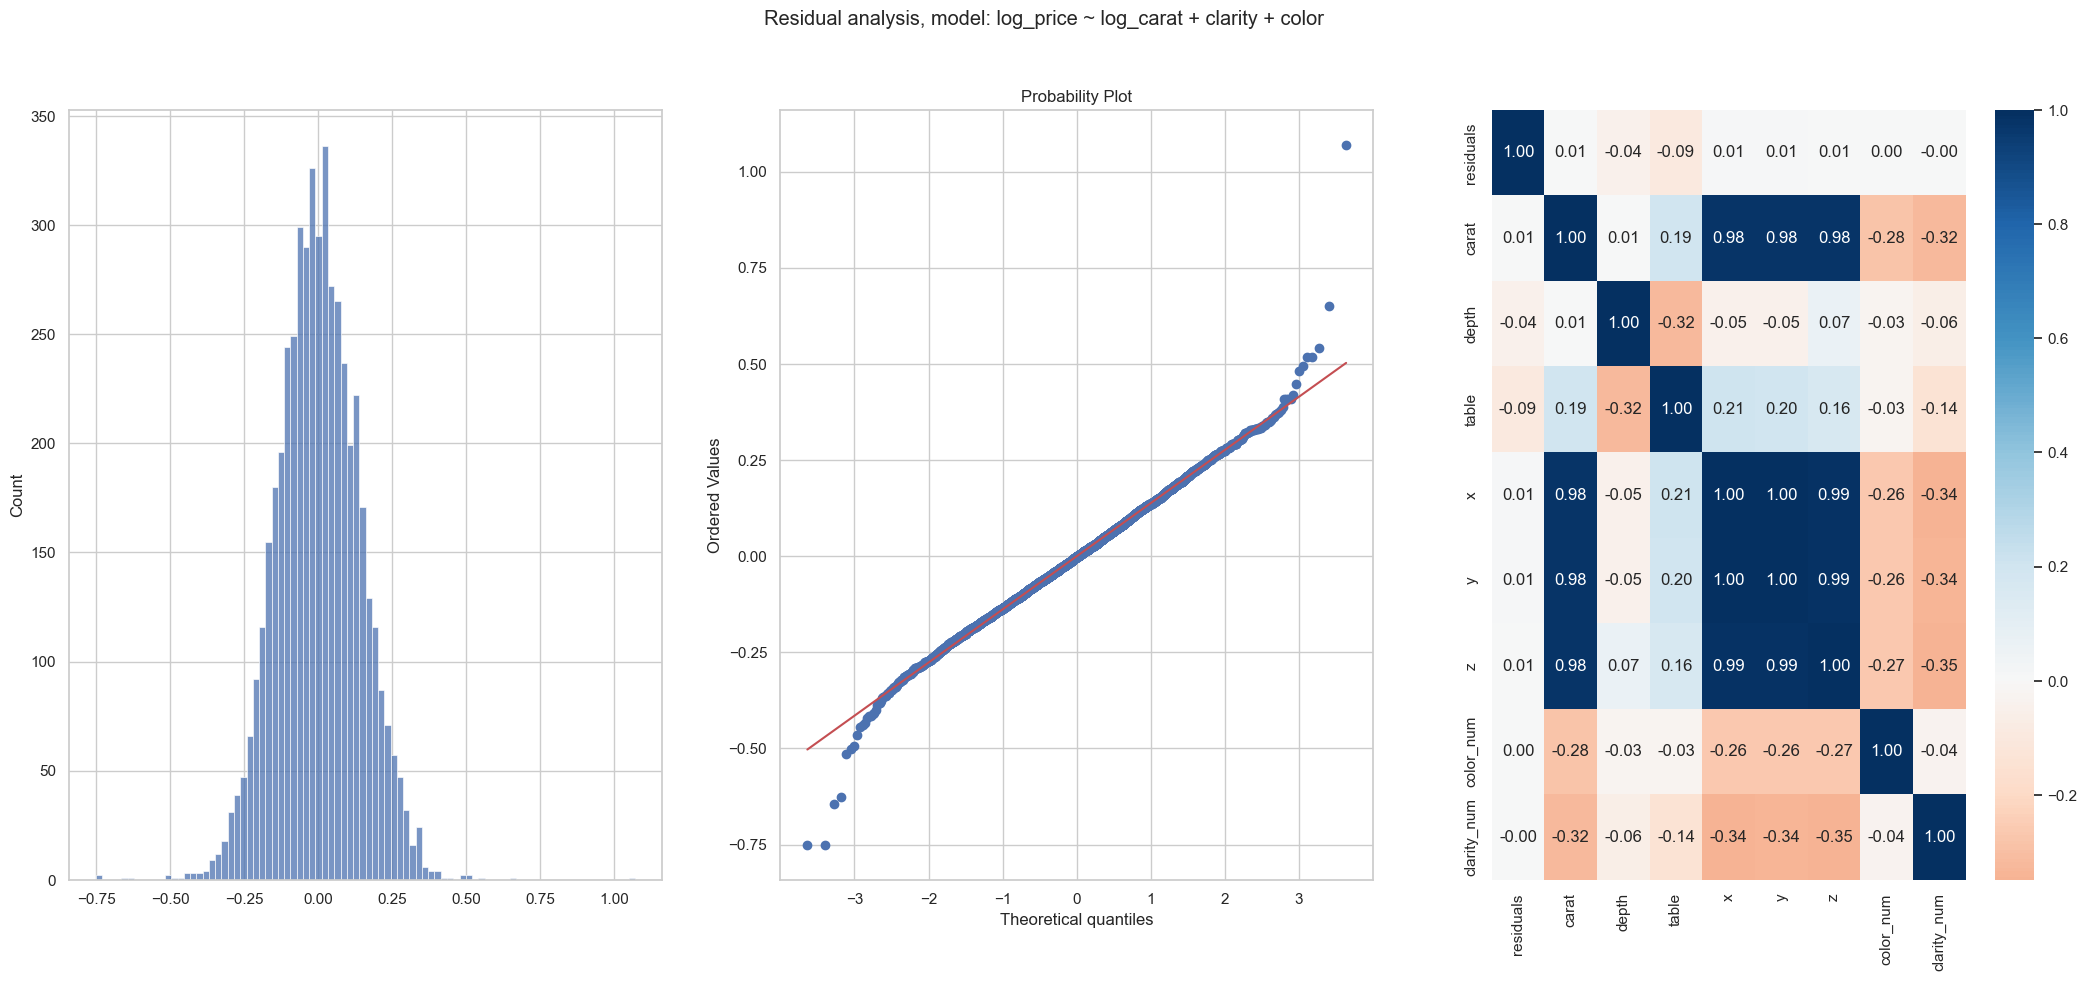

In [23]:
# Select the model to assess
model_idx = 2

# Run statistical test
print('Assessing model ' + models_f[model_idx])
run_statistical_Test(models[model_idx].resid)

# Plot residuals distribution, QQ-PLot and correlatiosn matrix
fig, axes = plt.subplots(1, 3, figsize = (26, 10))
sns.histplot(models[model_idx].resid, ax = axes[0], label = 'Residuals Distribution')
probplot(models[model_idx].resid, plot = axes[1])
df['residuals'] = models[model_idx].resid
sns.heatmap(df[['residuals'] + numerical_variables].corr(), annot=True, fmt=".2f", center=0, cmap = 'RdBu', ax = axes[2])
del df['residuals']

fig.suptitle('Residual analysis, model: ' + models_f[model_idx])

Adding the clarity and color predictors reduces the tails of the residuals distribution although it still is not a normal distribution according to the Shapiro-Wilk test. The residuals seem to be largely uncorrelated with all the remaining predictors

Assessing model log_price ~ log_carat + clarity + color + log_table + log_depth
One-sample T-test Results:
Statistic: -6.3554941385740875e-12
P-value: 0.9999999999949293
Residuals have a mean of zero (fail to reject H0)
Shapiro-Wilk Test Results:
Statistic: 0.9931042828996256
P-value: 8.196859160724903e-15
Residuals are not normally distributed (reject H0)


Text(0.5, 0.98, 'Residual analysis, model: log_price ~ log_carat + clarity + color + log_table + log_depth')

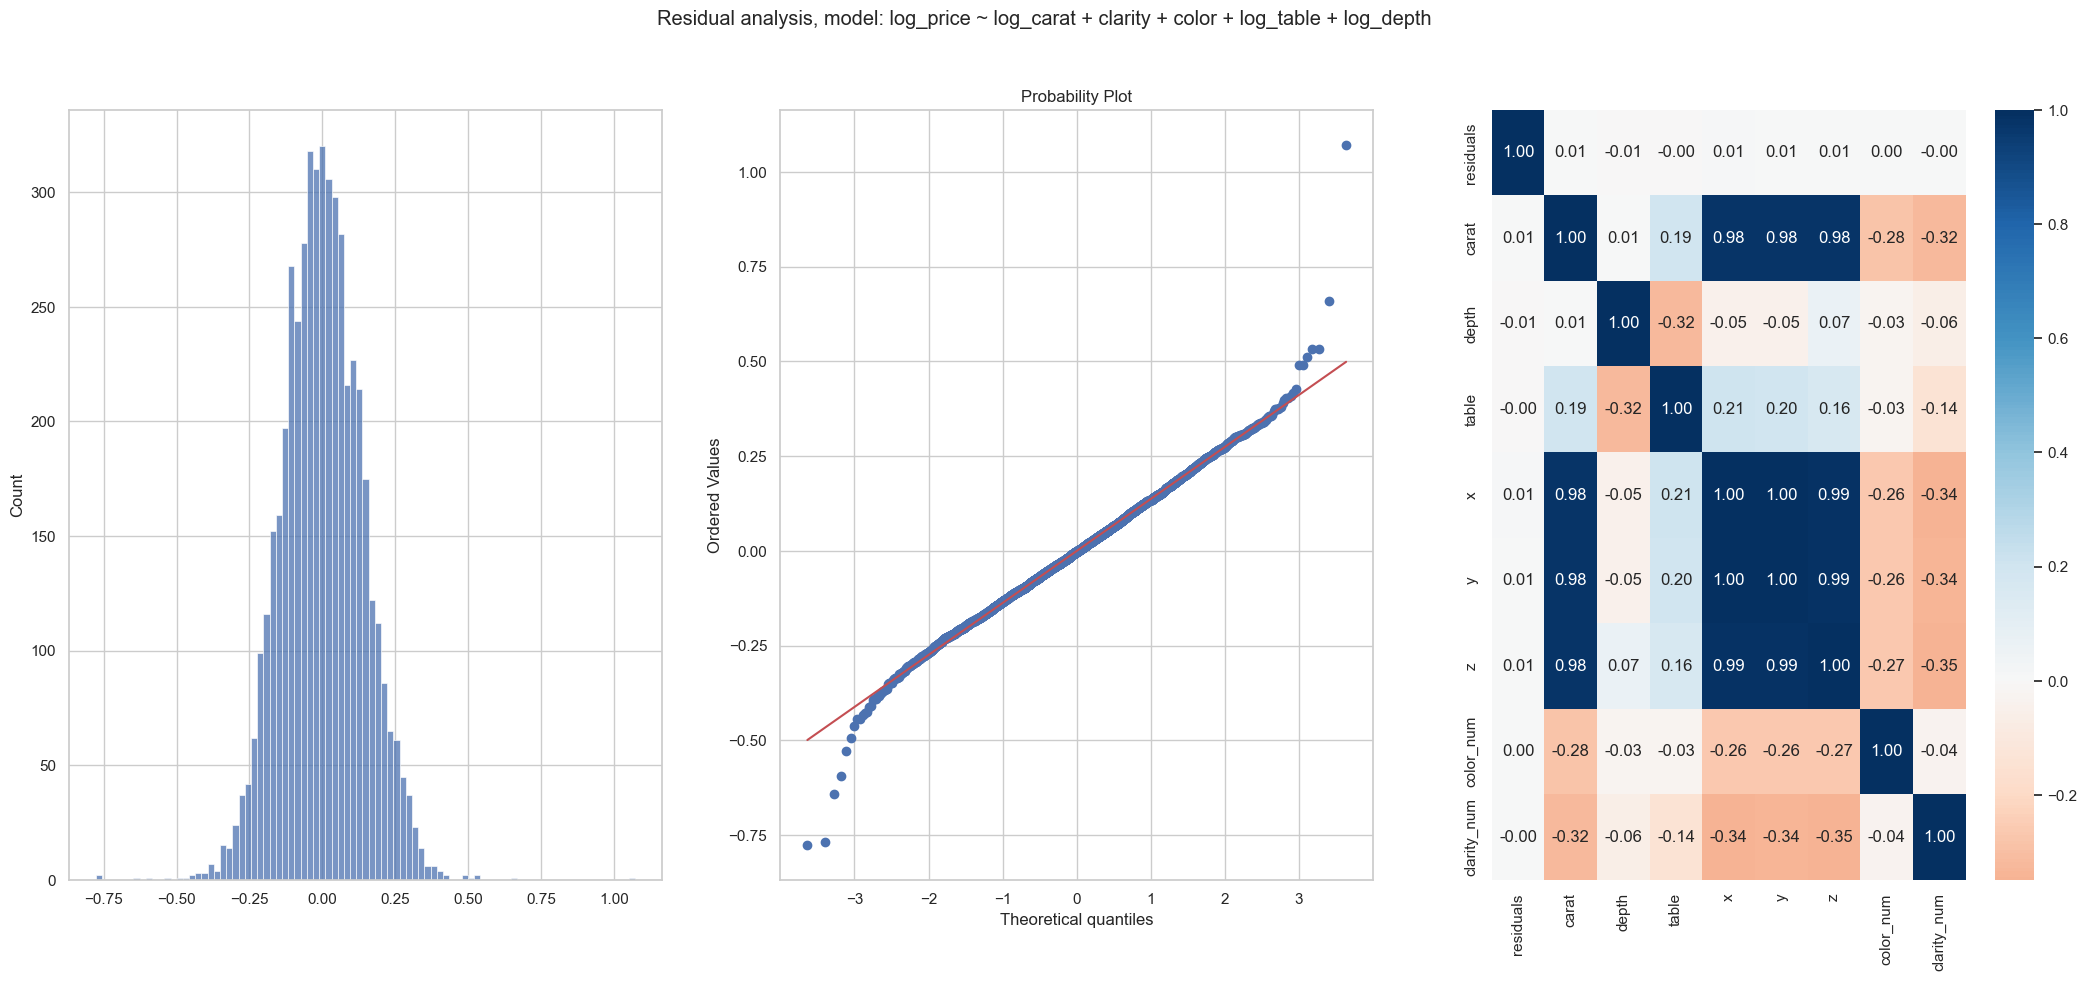

In [24]:
# Select the model to assess
model_idx = -1

# Run statistical test
print('Assessing model ' + models_f[model_idx])
run_statistical_Test(models[model_idx].resid)

# Plot residuals distribution, QQ-PLot and correlatiosn matrix
fig, axes = plt.subplots(1, 3, figsize = (26, 10))
sns.histplot(models[model_idx].resid, ax = axes[0], label = 'Residuals Distribution')
probplot(models[model_idx].resid, plot = axes[1])
df['residuals'] = models[model_idx].resid
sns.heatmap(df[['residuals'] + numerical_variables].corr(), annot=True, fmt=".2f", center=0, cmap = 'RdBu', ax = axes[2])
del df['residuals']

fig.suptitle('Residual analysis, model: ' + models_f[model_idx])